### **Prática de Correção Atmosférica**

* * *

**Bibliotecas requeridas:**

In [1]:
from Py6S import *
import os
import numpy as np
import pandas as pd
from osgeo import gdal
import ee
import geemap
from matplotlib import pyplot as plt

#ee.Authenticate()
ee.Initialize()

gdal.UseExceptions()

# Diretório de trabalho
print(f'Diretório de trabalho: {os.getcwd()}')

Diretório de trabalho: C:\Users\Usuario\Documents\correcao_atmosferica


**Variáveis atmosféricas:**

In [14]:
# Região de interesse
roi = ee.Geometry.BBox(-46.00, -23.29,-45.76, -23.13)

# Recuperar AOD via GEE [adimensional]
aod_550 = (
    
    ee.ImageCollection('MODIS/061/MCD19A2_GRANULES')
    .filterDate('2024-04-05T12:00:00', '2024-04-05T16:00:00')
    .filterBounds(roi)
    .select('Optical_Depth_055')
    .mean()
    .reduceRegion(reducer=ee.Reducer.mean(), geometry=roi)
    .getNumber('Optical_Depth_055')
    .multiply(0.001)
    .getInfo()

)

print(f'AOD média na área de interesse: {aod_550:.3f}')

# Recuperar altitude via GEE [km]
altitude = (
    
    ee.Image('NASA/NASADEM_HGT/001')
    .reduceRegion(reducer=ee.Reducer.mean(), geometry=roi)
    .getNumber('elevation')
    .divide(1e3)
    .getInfo()

)

print(f'Altitude média da área de interesse: {altitude*1e3:.0f} m')

ozone = (
    
    ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_O3')
    .filterDate('2024-04-05', '2024-04-06')
    .filterBounds(roi)
    .select('O3_column_number_density')
    .mean()
    .reduceRegion(reducer=ee.Reducer.mean(), geometry=roi)
    .getNumber('O3_column_number_density')
    .multiply(2.238)
    .getInfo()

)

print(f'Ozônio médio na área de interesse: {ozone:.3f} DU')

water = (

    ee.ImageCollection('NOAA/CFSR')
    .filterDate('2024-04-05', '2024-04-06')
    .filterBounds(roi)
    .select('Precipitable_water_entire_atmosphere_single_layer')
    .mean()
    .reduceRegion(reducer=ee.Reducer.mean(), geometry=roi)
    .getNumber('Precipitable_water_entire_atmosphere_single_layer')
    .divide(10)
    .getInfo()

)

print(f'Água na atmosfera na área de interesse: {water:.2f} g/cm²')

# Visualizar ROI
Map = geemap.Map()
Map.addLayer(roi)
Map.centerObject(roi, zoom=12)
Map

AOD média na área de interesse: 0.111
Altitude média da área de interesse: 604 m
Ozônio médio na área de interesse: 0.254 DU
Água na atmosfera na área de interesse: 2.06 g/cm²


Map(center=[-23.209999207833334, -45.88000000000177], controls=(WidgetControl(options=['position', 'transparen…

**Variáveis da cena:**

In [3]:
day = 5
month = 4

# Ângulo azimutal e zenital do sol [graus]
sun_a = 44.40
sun_z = 39.20

# Ângulo azimutal e zenital do sensor [graus]
sensor_a = np.mean([233.41, 235.37, 234.82, 234.06, 240.52, 237.91,
                   236.17, 238.97, 234.41, 233.97, 233.12, 235.33, 233.06])

sensor_z = np.mean([3.94, 3.65, 3.72, 3.70, 3.38, 3.48, 3.58, 3.43,
                   3.80, 3.87, 4.03, 3.53, 3.88])

**Inicialização do modelo 6S:**

In [4]:
# Inicializa
s = SixS()

# Criação de um perfil atmosférico predefinido
s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
#s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)

**Criação de perfil de AOD:**

In [5]:
s.aot550 = aod_550
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)

**Criar geometria e configurar parâmetros:**

In [6]:
s.geometry = Geometry.User()
s.geometry.day = day
s.geometry.month = month
s.geometry.solar_z = sun_z
s.geometry.solar_a = sun_a
s.geometry.view_z = sensor_z
s.geometry.view_a = sensor_a

**Configurar altitude:**

In [7]:
s.altitudes = Altitudes()

# Informa que o sensor é orbital
s.altitudes.set_sensor_satellite_level()

# Informa altitude do alvo (km)
s.altitudes.set_target_custom_altitude(altitude)

**Função para interpolar comprimentos de onda:**

In [8]:
def interpolar_bandas(rsr, band_number: int, range_w: list) -> dict:
    output = {}
    bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
    for i in range(1, band_number + 1):
        filter_ = rsr.loc[rsr['id'] == i]
        w_min_ = np.min(filter_['wavelength'])
        w_max_ = np.max(filter_['wavelength'])
        wavelength_ = [np.around(w, 3) for w in np.arange(w_min_, w_max_, 0.001)]
        wavelength_int = [np.around(w, 3) for w in np.arange(range_w[0], range_w[1], 0.001)]
        wavelength_sub = list(set(wavelength_int) - set(wavelength_))
        df_ = pd.DataFrame({'wavelength': wavelength_sub, 'rsr': int(0), 'band': str(i)})
        df_ = pd.concat([filter_, df_]).sort_values(by=['wavelength'], ascending=True)
        d_select = df_['rsr'].to_list()
        wavelength_interp = [np.around(w, 4) for w in np.arange(range_w[0], range_w[1], 0.0025)]
        norm = np.interp(wavelength_interp, df_['wavelength'].to_list(), d_select).tolist()
        out_ = [norm, [i for i in wavelength_interp]]
        output[bands[i - 1]] = out_
    return output

**Funções de resposta espectral:**

In [9]:
rsr = pd.read_table('auxiliar/rsr_S2B_MSI.txt',
                    sep='\t',
                    skiprows=5,
                    names=['wavelength', 'rsr', 'band', 'id'])

**Interpolação:**

In [10]:
bands = interpolar_bandas(rsr, 13, [0.412, 2.321])

**Passar comprimentos de onda para o modelo:**

In [11]:
atm_params = {}

for i in ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']:

    s.wavelength = Wavelength(np.min(bands[i][1]), np.max(bands[i][1]), bands[i][0])

    s.run()    
    
    atm_params[i] = {'tg_OG_co': float(s.outputs.transmittance_co.total),
                    'tg_OG_co2': float(s.outputs.transmittance_co2.total),
                    'tg_OG_o2': float(s.outputs.transmittance_oxygen.total),
                    'tg_OG_no2': float(s.outputs.transmittance_no2.total),
                    'tg_OG_o3': float(s.outputs.transmittance_ozone.total),
                    'tg_OG_ch4': float(s.outputs.transmittance_ch4.total),
                    'tg_OG_h2o': float(s.outputs.transmittance_water.total),
                    't_upward': float(s.outputs.transmittance_total_scattering.upward),
                    't_downward': float(s.outputs.transmittance_total_scattering.downward),
                    'p_atm': float(s.outputs.atmospheric_intrinsic_reflectance),
                    's': float(s.outputs.spherical_albedo.total)}

**Funções para abrir e salvar imagens:**

In [12]:
def abrir_imagem(path: str):
    dataset = gdal.Open(path)
    return dataset.ReadAsArray().astype(float)


def salvar_imagem(array: float, index: str, reference: str, dest: str) -> None:

    filename_reference = reference
    filename_out_factor = dest + '/' + index[0:-4] + '.TIF'
    dataset_reference = gdal.Open(filename_reference)

    line = dataset_reference.RasterYSize
    column = dataset_reference.RasterXSize
    bands = 1

    driver = gdal.GetDriverByName('GTiff')
    data_type = gdal.GetDataTypeByName('Float32')
    dataset_output = driver.Create(filename_out_factor, column, line, bands, data_type)
    dataset_output.SetGeoTransform(dataset_reference.GetGeoTransform())
    dataset_output.SetProjection(dataset_reference.GetProjectionRef())
    dataset_output.GetRasterBand(1).WriteArray(array)
    dataset_output=None
    return None

**Processamento das imagens:**

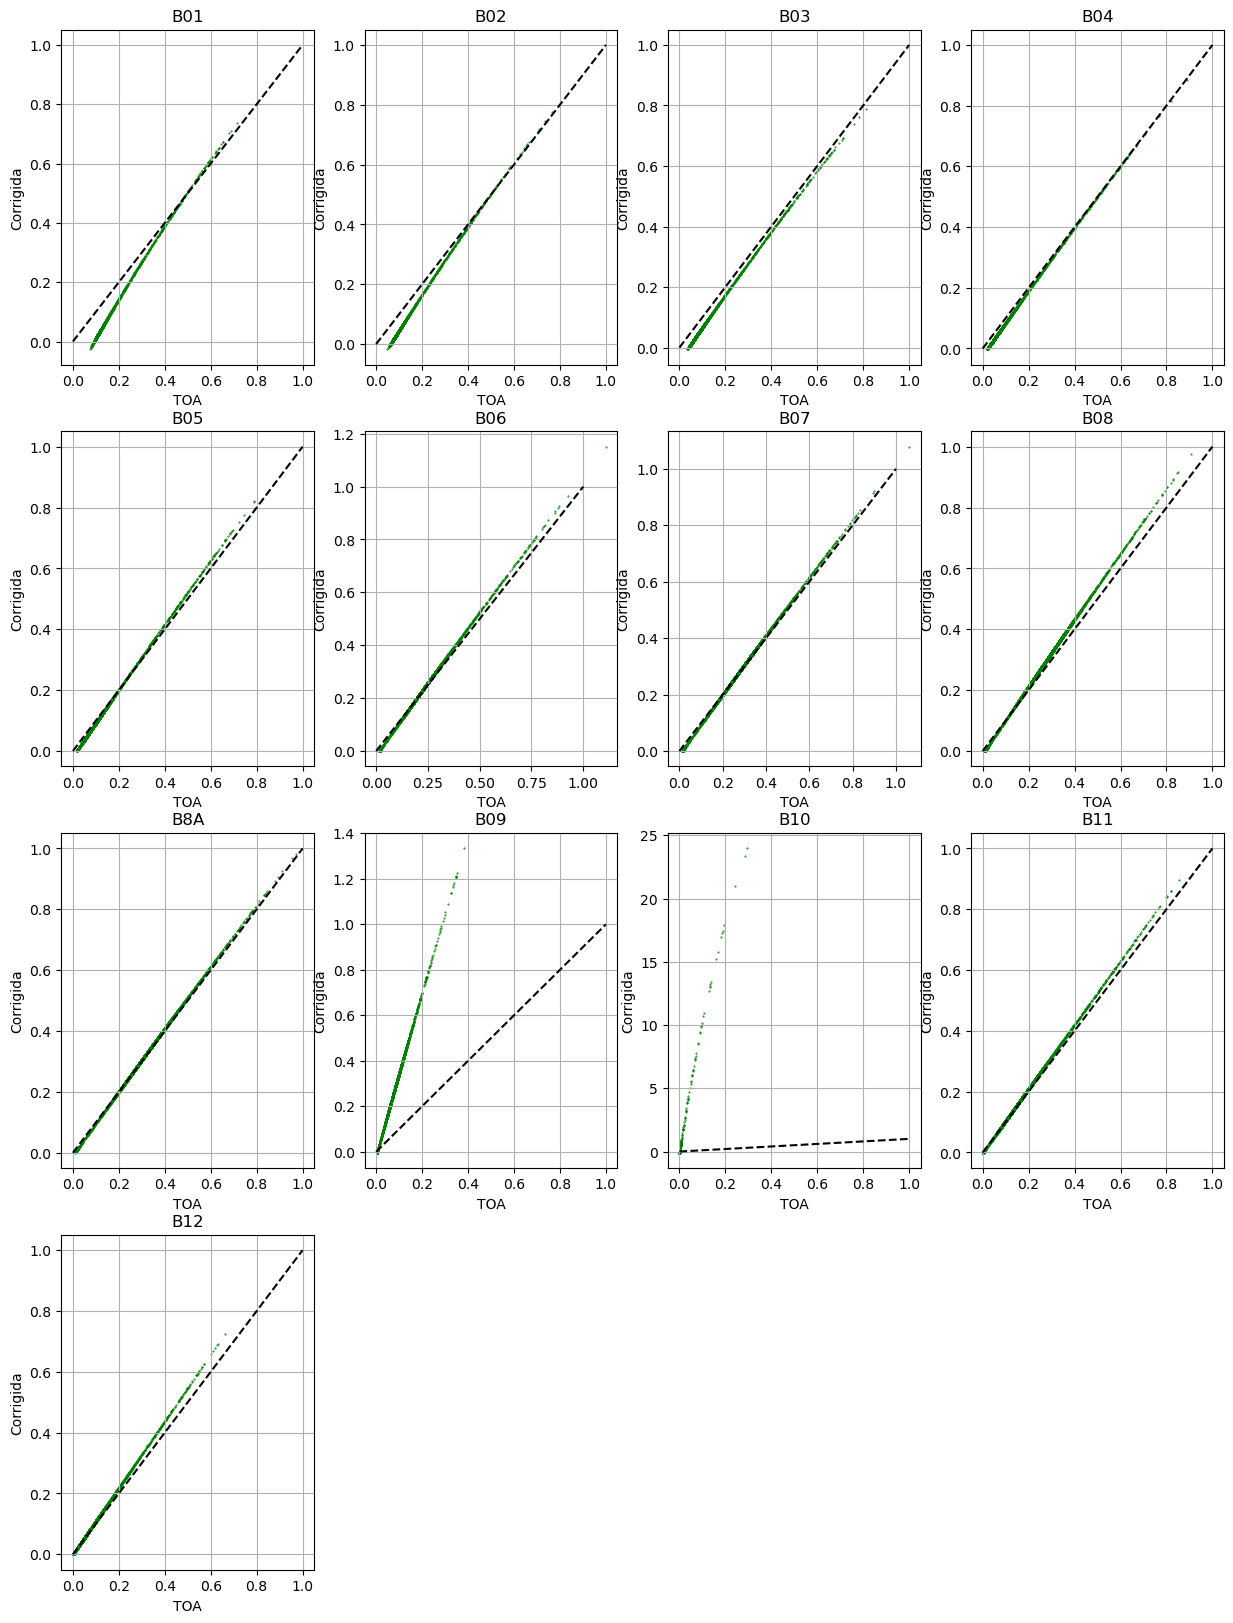

In [13]:
# Diretório das imagens TOA
img_dir = 'dados_toa'

# Fatores de conversão para bandas Sentinel-2
quantification_value = 10000
radio_add_offset = -1000

sp = 1
plt.figure(figsize=(15, 20))

# Iterar sobre as bandas
for band in atm_params:

    img_id = [i for i in os.listdir(img_dir) if band in i][0]

    img_path = f'{img_dir}/{img_id}'

    ref_toa = (abrir_imagem(img_path) + radio_add_offset) / quantification_value

    filter = np.random.uniform(0, len(ref_toa.flatten() - 1), 10000).astype(int)

    t_atm = atm_params[band]['t_upward'] * atm_params[band]['t_downward']
    tg = atm_params[band]['tg_OG_co'] * atm_params[band]['tg_OG_co2'] * atm_params[band]['tg_OG_ch4'] * atm_params[band]['tg_OG_o2']
    tg_h2o = atm_params[band]['tg_OG_h2o']
    tg_o3 = atm_params[band]['tg_OG_o3']
    p_atm = atm_params[band]['p_atm']
    s = atm_params[band]['s']

    A = (ref_toa / tg * tg_o3 - p_atm) / (t_atm * tg_h2o)

    ref_sup = A / (1 + (A * s))
    
    plt.subplot(4, 4, sp)
    plt.scatter(x=ref_toa.flatten()[filter], y=ref_sup.flatten()[filter], color='green', s=.2, label='Usando +')
    #plt.scatter(x=ref_toa.flatten()[filter], y=ref_sup2.flatten()[filter], color='red', s=.2, label='Usando -')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='y=x')
    plt.xlabel('TOA')
    plt.ylabel('Corrigida')
    plt.grid()
    #plt.legend()
    plt.title(band)

    sp += 1
    
    salvar_imagem(ref_sup, img_id, img_path, 'dados_sup')
    salvar_imagem(ref_toa, img_id, img_path, 'dados_toa_scaled')